In [2]:
%load_ext autoreload
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from utils import languages, get_trigrams_sets, encode, prepare_dataframe, normalize, \
    FFN_Hyperparams, build_model, create_encoder, test_model, create_feature_dictionary, sentences_by_lang
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Przygotowanie danych

In [3]:
print(languages)
print(sentences_by_lang)

['eng', 'deu', 'spa', 'ita', 'por', 'fra']
200000


In [4]:
df = prepare_dataframe()

In [5]:
all_trigrams, _ = get_trigrams_sets(df)

### Bag of words

In [6]:
# Tworzymy bag of words, nie wykorzystujemy binarnego bag of words ponieważ trigramy w zdaniu mogą się powtórzyć i stracilibyśmy tę informację.
# Wadą BoW jest fakt, że każdy trigram jest tak samo ważny, ale w naszym problemie to nie przeszkadza.
dic = create_feature_dictionary(all_trigrams)

vectorizer = CountVectorizer(vocabulary=dic, ngram_range=(3,3), analyzer="char") #ngram_range bierzemy tylko trigramy, analyzer bierzemy pod uwagę znaki,// char_wb nie zliczało poprawnie kolumn
sentences = df["sentence"]
langs = df["lang"]
X = vectorizer.fit_transform(sentences)
# Tworzymy macierz wystąpień poszcególnych trigramów
features = pd.DataFrame(data=X.toarray(), columns=all_trigrams)

### Normalizacja

In [7]:
features = normalize(features)
features["lang"] = list(langs) # dodajemy dodatkową kolumnę z naszym outputem

### Podział na dane testowe i treningowe

In [8]:
encoder = create_encoder()
x = features.drop('lang',axis=1)
y = encode(features['lang'], encoder)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

### Przygotowanie modelu

In [9]:
params = FFN_Hyperparams(len(X_train.columns), len(languages), [500,500,250], 'relu')
model = build_model(params)

### INFO o urządzeniach

In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Uruchomienie treningu

In [11]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [12]:
# Z użyciem gpu
#with tf.device('/GPU:0'):


# Sample - jeden wiersz danych wejściowych - jeden przykład.
# Batch - po ilu samplach, które przeszły przez sieć zaktualizować wagi.
# Batch Gradient Descent. Batch Size = Size of Training Set
# Stochastic Gradient Descent. Batch Size = 1
# Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set
# Epoch - ile razy cały training set przeszedł przez sieć.
# Learning rate - jak szybko funkcja kosztu schodzi do minimum
train_gen = DataGenerator(X_train, y_train, 32)
length = int(len(X_train)/2)
history = model.fit(train_gen, epochs=20, batch_size=6)

Epoch 1/6
30000/30000 [==============================] - 123s 4ms/step - loss: 0.0804 - accuracy: 0.9715
Epoch 2/6
30000/30000 [==============================] - 125s 4ms/step - loss: 0.0598 - accuracy: 0.9814
Epoch 3/6
30000/30000 [==============================] - 123s 4ms/step - loss: 0.0421 - accuracy: 0.9849
Epoch 4/6
30000/30000 [==============================] - 114s 4ms/step - loss: 0.0370 - accuracy: 0.9871
Epoch 5/6
30000/30000 [==============================] - 119s 4ms/step - loss: 0.0314 - accuracy: 0.9888
Epoch 6/6
30000/30000 [==============================] - 121s 4ms/step - loss: 0.0341 - accuracy: 0.9900


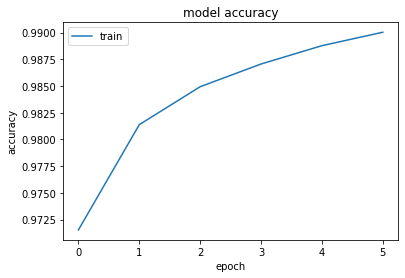

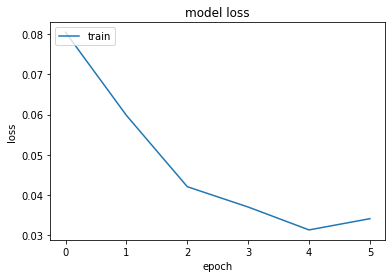

In [13]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Test precyzji

In [14]:
accuracy = test_model(model, encoder, X_test, y_test)

7500/7500 [==============================] - 10s 1ms/step


In [15]:
print("Accuracy: ", accuracy)
if accuracy > 0.9:
    model.save("trigrams_recognition")
    with open('trigrams_labels.pkl', 'wb') as f:
        pickle.dump(encoder.classes_, f)
    with open('trigrams_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

Accuracy:  0.9840375
INFO:tensorflow:Assets written to: trigrams_recognition\assets


In [16]:
train_gen = DataGenerator(X_train, y_train, 32)
length = int(len(X_train)/2)
history = model.fit(train_gen, epochs=20, batch_size=6)

Epoch 1/20
30000/30000 [==============================] - 135s 4ms/step - loss: 0.0244 - accuracy: 0.9910
Epoch 2/20
30000/30000 [==============================] - 124s 4ms/step - loss: 0.0712 - accuracy: 0.9917
Epoch 3/20
30000/30000 [==============================] - 125s 4ms/step - loss: 0.0228 - accuracy: 0.9924
Epoch 4/20
30000/30000 [==============================] - 125s 4ms/step - loss: 0.0198 - accuracy: 0.9927
Epoch 5/20
30000/30000 [==============================] - 124s 4ms/step - loss: 0.0185 - accuracy: 0.9932
Epoch 6/20
30000/30000 [==============================] - 124s 4ms/step - loss: 0.0181 - accuracy: 0.9936
Epoch 7/20
30000/30000 [==============================] - 131s 4ms/step - loss: 0.0231 - accuracy: 0.9938
Epoch 8/20
30000/30000 [==============================] - 126s 4ms/step - loss: 0.0159 - accuracy: 0.9941
Epoch 9/20
30000/30000 [==============================] - 125s 4ms/step - loss: 0.0165 - accuracy: 0.9944
Epoch 10/20
30000/30000 [=====================

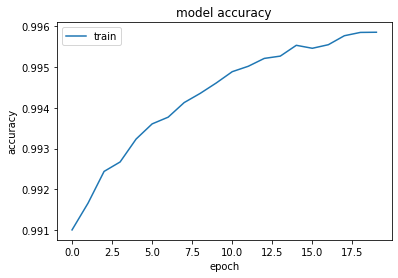

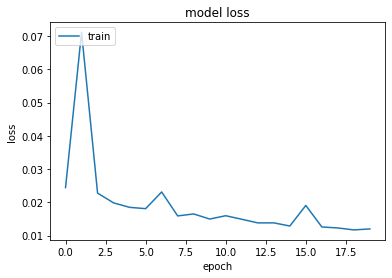

In [17]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
accuracy = test_model(model, encoder, X_test, y_test)

7500/7500 [==============================] - 11s 1ms/step


In [19]:
print("Accuracy: ", accuracy)
if accuracy > 0.9:
    model.save("trigrams_recognition")
    with open('trigrams_labels.pkl', 'wb') as f:
        pickle.dump(encoder.classes_, f)
    with open('trigrams_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

Accuracy:  0.9839458333333333
INFO:tensorflow:Assets written to: trigrams_recognition\assets
